In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Plots for static objectives (7 enemies_)

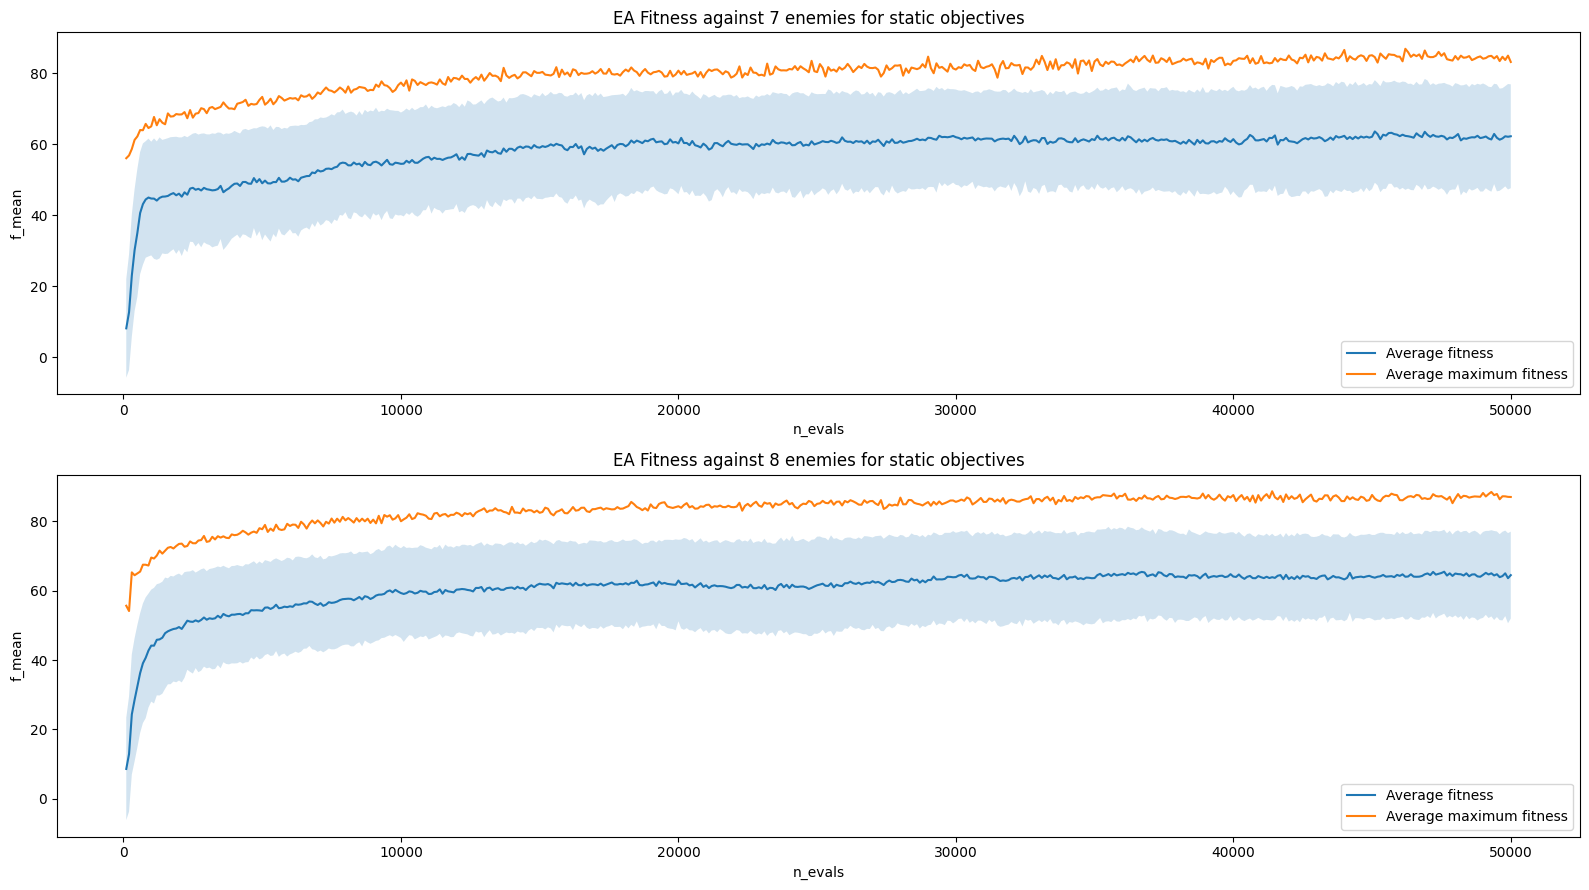

In [35]:
solutions = dict()
solutions[7] = []
solutions[8] = []

fig, ax = plt.subplots(2, figsize=(16, 9))
for i, n_enemies in enumerate([7, 8]):
    fitness_mean_grouped = []
    fitness_max_grouped = []
    fitness_std_grouped = []
    
    for s in os.listdir(f'plotdata/Static objectives {n_enemies} enemies trained'):
        if s.endswith('.csv'):
            df = pd.read_csv(f'plotdata/Static objectives {n_enemies} enemies trained/{s}')
            f = [f'f{j}' for j in range(1, n_enemies+1)]            
            df['f_mean'] = df[f].mean(axis=1)
            
            fitness_mean = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).mean().reset_index()
            fitness_mean = fitness_mean.set_index('n_evals')['f_mean']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max = fitness_max.set_index('n_evals')['f_mean']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std = fitness_std.set_index('n_evals')['f_mean']
            fitness_std_grouped.append(fitness_std)

    fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_evals').mean()
    fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_evals').mean()
    fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_evals').mean()
    
    # Plot average and max
    sns.lineplot(fitness_mean_agg,
                ax=ax[i], label='Average fitness')
    sns.lineplot(fitness_max_agg,
                ax=ax[i], label='Average maximum fitness')

    ax[i].fill_between(fitness_mean_agg.index, 
                        fitness_mean_agg - fitness_std_agg, 
                        fitness_mean_agg + fitness_std_agg, 
                        alpha=0.2)


    # Plot legend
    ax[i].legend(loc=4)
    ax[i].set_title(f'EA Fitness against {n_enemies} enemies for static objectives')

# Show
fig.tight_layout()
plt.show();

# Plots for dynamic objectives

In [36]:
# Dynamic objectives
# N_eval = N_iter * 200

fitness_mean_grouped = []
fitness_max_grouped = []
fitness_std_grouped = []

for d in os.listdir('plotdata/Dynamic objectives'):
    if d == '1-4':
        d = '1-4/final_generalist_assignment'
        
    for f in os.listdir(f'plotdata/Dynamic objectives/{d}'):
        if f.endswith('.csv') and f.startswith('dynamic_objectives') and 'secondary' not in f and not f.startswith('dynamic_objectives_5'):
            df = pd.read_csv(f'plotdata/Dynamic objectives/{d}/{f}')
            
            fitness_mean = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).mean().reset_index()
            fitness_mean['n_eval'] = 200 * fitness_mean['n_iter'] + 20 * fitness_mean['n_gens']
            fitness_mean = fitness_mean.set_index('n_eval')['mean_obj']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max['n_eval'] = 200 * fitness_max['n_iter'] + 20 * fitness_max['n_gens']
            fitness_max = fitness_max.set_index('n_eval')['max_obj']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std['n_eval'] = 200 * fitness_std['n_iter'] + 20 * fitness_std['n_gens']
            fitness_std = fitness_std.set_index('n_eval')['std_obj']
            fitness_std_grouped.append(fitness_std)

fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_eval').mean()
fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_eval').mean()
fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_eval').mean()

In [37]:
max_beaten_dynamic = []
for d in os.listdir('plotdata/Dynamic objectives'):
    if d == '1-4':
        d = '1-4/final_generalist_assignment'
        
    for f in os.listdir(f'plotdata/Dynamic objectives/{d}'):
        if f.endswith('.csv') and f.startswith('max'):
            df = pd.read_csv(f'plotdata/Dynamic objectives/{d}/{f}')
            for i in range(df.shape[0]):
                # Handle first two values
                if i == 0:
                    pass
                elif i == 1:
                    df.iloc[i, 0:2] = [1, 200]
                # Handle double values
                if df.iloc[i, 1] == df.iloc[i-1, 1]:
                    df.iloc[i, 0] += 1
                    df.iloc[i, 1] += 200
            
            max_beaten_dynamic.append(df)

max_beaten_dynamic = pd.concat(max_beaten_dynamic).reset_index(drop=True)
# max_beaten_dynamic['max_enemies_beaten_roll'] = max_beaten_dynamic['max_enemies_beaten'].rolling(50).mean()
max_beaten_dynamic

,n_iter,n_evals,max_enemies_beaten
0,0,0,3
1,1,200,3
2,2,400,3
3,3,600,4
4,4,800,4
...,...,...,...
2515,247,49400,7
2516,248,49600,7
2517,249,49800,7
2518,250,50000,7


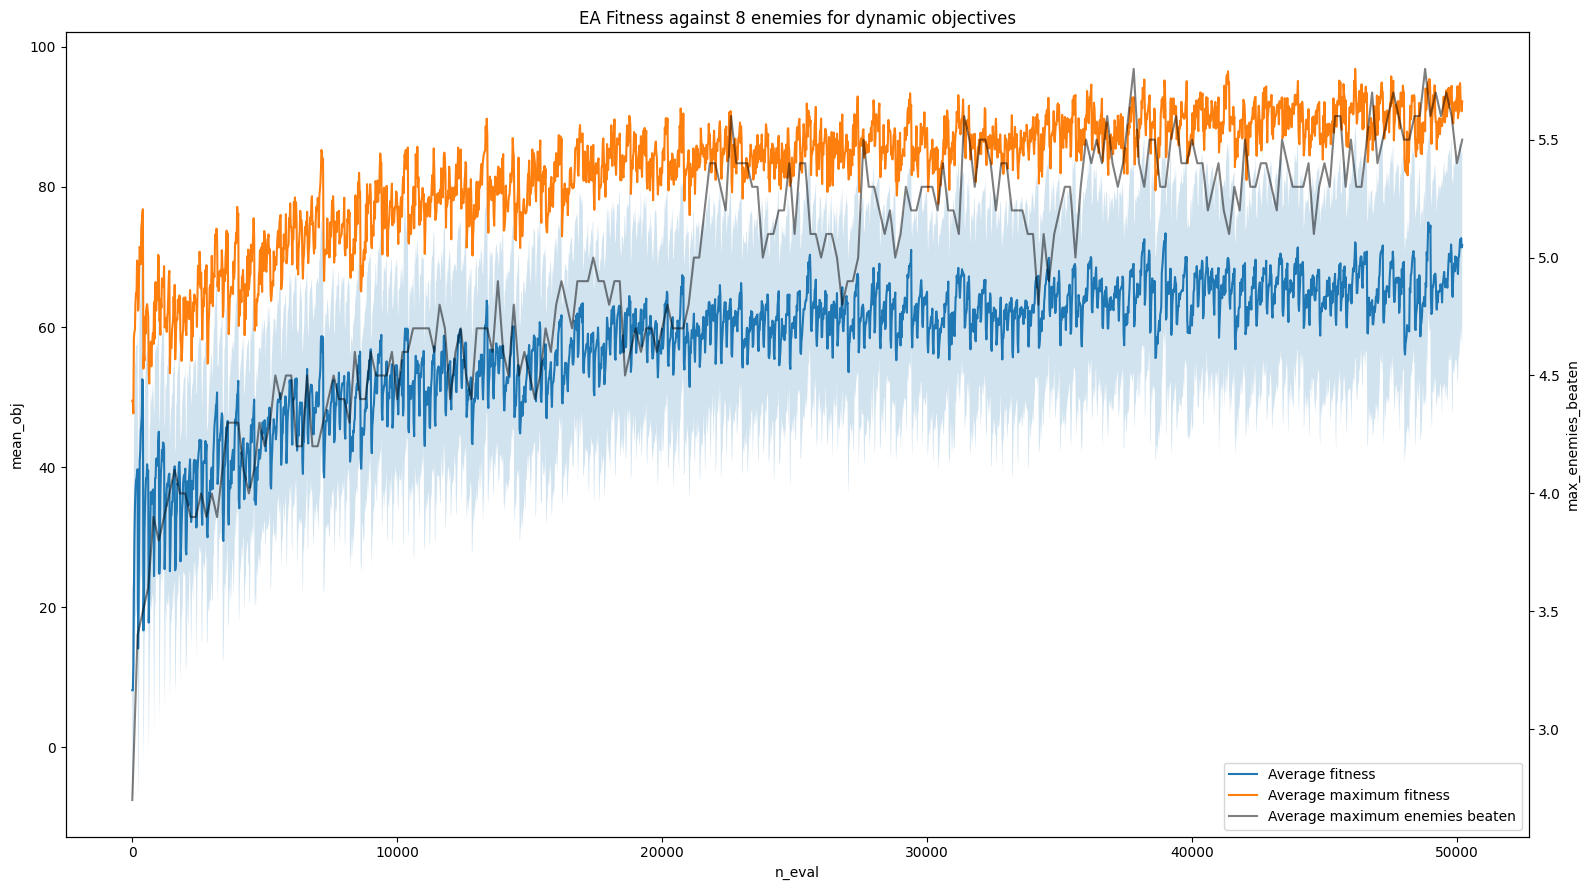

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))

# Plot average and max
sns.lineplot(fitness_mean_agg,
             ax=ax, label='Average fitness')
sns.lineplot(fitness_max_agg,
             ax=ax, label='Average maximum fitness')

ax.fill_between(fitness_mean_agg.index, 
                fitness_mean_agg - fitness_std_agg, 
                fitness_mean_agg + fitness_std_agg, 
                alpha=0.2)

# Plot max enemies beaten
ax2 = ax.twinx()
sns.lineplot(data=max_beaten_dynamic, x='n_evals', y='max_enemies_beaten',
             ax=ax2, label='Average maximum enemies beaten', legend=None,
             color='black', errorbar=None, alpha=0.5)

# Plot legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, loc=4)
ax.set_title('EA Fitness against 8 enemies for dynamic objectives')

# Show
fig.tight_layout()
plt.show();

# Boxplots

In [27]:
import numpy as np
import ast

algorithm_gain = []

## Have to import random search separately as it needs to be parsed first
batch_gain = []
random_solutions = []
for f in os.listdir('plotdata/boxplotdata/random_search_performance_generalist'):
    data = pd.read_csv(f'plotdata/boxplotdata/random_search_performance_generalist/{f}', index_col=0)
    random_solutions.append(data)
    
random_solutions = pd.concat(random_solutions)
# Group in batches of 50 000 (SLOW)
for k, g in random_solutions.groupby(np.arange(len(random_solutions))//50000):
    data = g.copy()
    
    # Lists in dataframe are stored as string, so first convert back to list
    data['enemy lives'] = data['enemy lives'].apply(lambda x: ast.literal_eval(x))
    data['player lives'] = data['player lives'].apply(lambda x: ast.literal_eval(x))
    
    # Make NP array of lists for substraction
    data[['enemy lives', 'player lives']] = data[['enemy lives', 'player lives']].map(np.array)
    data['individual gain'] = data['player lives'] - data['enemy lives']
    data['individual gain'] = data['individual gain'].apply(lambda x: sum(x))
    
    # Get the best performing solution per batch
    best_batch_gain = data[data['enemies beaten'] == data['enemies beaten'].max()].nlargest(1, 'individual gain')
    batch_gain.append(best_batch_gain)
    
random = pd.concat(batch_gain)[['enemies beaten', 'individual gain']].rename(columns={'enemies beaten': 'enemies_beaten', 'individual gain': 'ind_gain'})
random['file'] = 'random_search'
algorithm_gain.append(random)

# Afterwards, load in the rest
for f in os.listdir('plotdata/boxplotdata/'):
    if f.endswith('csv'):
        data = pd.read_csv(f'plotdata/boxplotdata/{f}', index_col=0)
        
        # Set file name so we can differentiate in the boxplot, can change name later
        data['file'] = f
        algorithm_gain.append(data)
    
algorithm_gain = pd.concat(algorithm_gain)
algorithm_gain.head()

,enemies_beaten,ind_gain,file
49242,4,37.8,random_search
77594,5,76.8,random_search
5132,5,77.2,random_search
61605,4,-37.2,random_search
35237,5,-143.8,random_search


C:\Users\beuze\AppData\Local\Temp\ipykernel_15004\2851693854.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=algorithm_gain,
C:\Users\beuze\AppData\Local\Temp\ipykernel_15004\2851693854.py:9: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(data=algorithm_gain,
C:\Users\beuze\AppData\Local\Temp\ipykernel_15004\2851693854.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=algorithm_gain,
C:\Users\beuze\AppData\Local\Temp\ipykernel_15004\2851693854.py:13: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.stripplot(data=algorithm_gain,


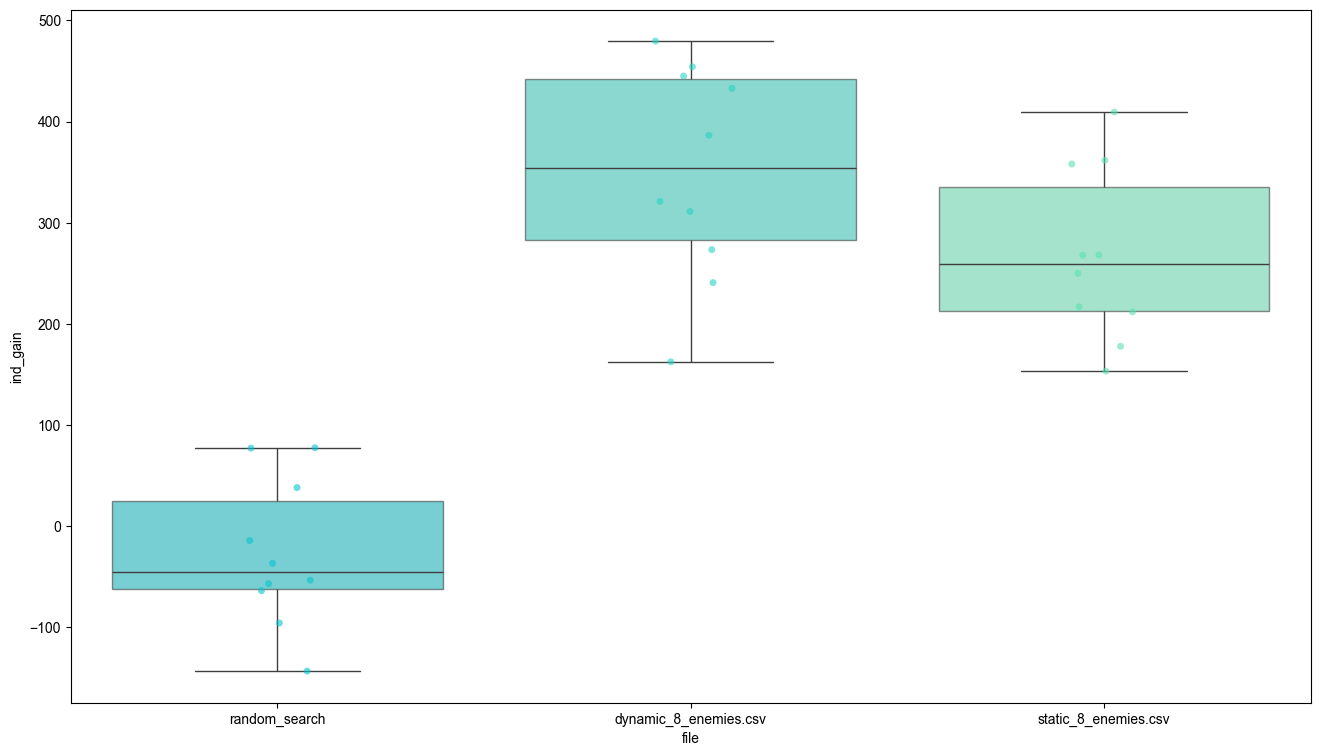

In [39]:
# Make subplot
fig, ax = plt.subplots(figsize=(16, 9))

# Set themes and colors
sns.set_theme()
palette = ['#04C5CF', '#26D4C4', '#5AE2B0', '#8DED99', '#F9F871']

# Plot!
sns.boxplot(data=algorithm_gain, 
            x='file', y='ind_gain', 
            palette=palette, boxprops=dict(alpha=0.6),)

sns.stripplot(data=algorithm_gain, 
            x='file', y='ind_gain', 
            palette=palette, alpha=0.6)

# Show!
plt.show();